In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# https://youtu.be/JNxcznsrRb8?t=1h50m26s

PATH="/home/ubuntu/cjt_fastai/fastai/courses/dl1/data/dogscats/"
print(torch.cuda.is_available())  # check that GPU is setup correctly 
print(torch.backends.cudnn.enabled) # check for accelerated fncs

sz=299
arch=resnext50
bs=28


True
True


In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 72/72 [00:41<00:00,  1.72it/s]


In [12]:
lrf = learn.lr_find() 


A Jupyter Widget

 70%|██████▉   | 573/822 [00:06<00:02, 94.93it/s, loss=0.0919] 


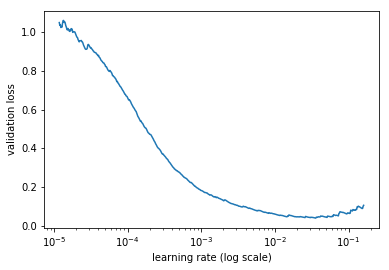

In [13]:
learn.sched.plot()

In [14]:
learn.fit(1e-2, 1)
learn.precompute=False

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.048047   0.020181   0.993     



In [15]:
learn.fit(1e-2, 2, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.034977   0.020079   0.994     
    1      0.051388   0.016046   0.995                        



[array([ 0.01605]), 0.99500000154972079]

In [16]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1) 
# note that we have a bigger arch with more parameters. JH found that with cycle_mult, it was rapidly overfitting.
# models with more parameters are (of course) more susceptible to over fitting

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.041463   0.016052   0.9945    
    1      0.022842   0.015363   0.995                        
    2      0.027682   0.01446    0.9945                       



[array([ 0.01446]), 0.99450000178813935]

In [59]:
# looks like we didn't get fully trained yet, (trn_loss > val_loss)
# try a few more epochs
learn.fit(lr, 2, cycle_len=1) 

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.031706   0.014162   0.9955    
    1      0.019892   0.016768   0.9955                       



[array([ 0.01677]), 0.99550000047683718]

In [60]:
learn.save('224_all_50')

In [61]:
learn.load('224_all_50')

In [75]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs,y)

0.99550000000000005

[[997   3]
 [  6 994]]


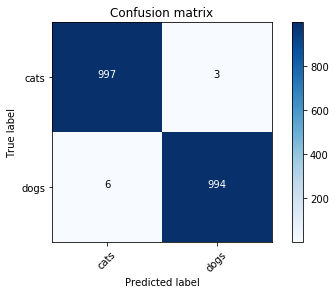

In [76]:
## inspect results
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [77]:
# make some helper functions 
def rand_by_mask(mask):
    # get 4 random images from class
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct):
    # get correct images 
    return rand_by_mask((preds==data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0]] for x in idxs)
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(imgs, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for ii in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, ii+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[ii], fontsize=16)
        plt.imshow(imgs[ii])
        
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult*probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds==data.val_y)==is_correct) \
            & (data.val_y==y), mult)

def get_augs(tfms):
    """Show augmentation images"""
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

Most incorrect cats


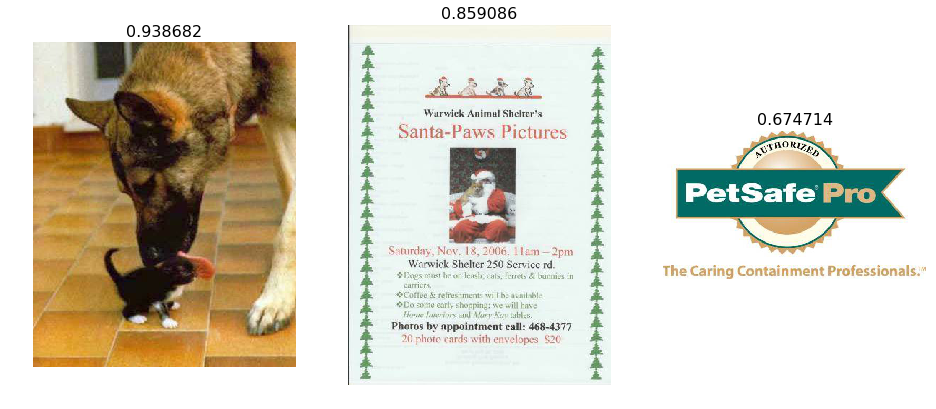

In [78]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


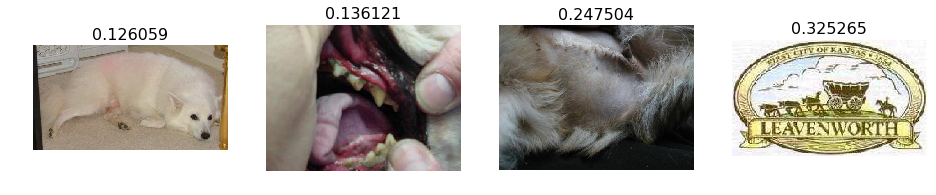

In [79]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")